# Optimization

Things to try:

- change the number of samples
- without and without bias
- with and without regularization
- changing the number of layers
- changing the amount of noise
- change number of degrees
- look at parameter values (high) in OLS
- tarin network for many epochs

In [10]:
from fastprogress.fastprogress import progress_bar

import torch

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

In [11]:
def plot_regression_data(model=None, MSE=None, poly_deg=0):

    # Plot the noisy scatter points and the "true" function
    plt.scatter(x_train, y_train, label="Noisy Samples")
    plt.plot(x_true, y_true, "--", label="True Function")

    # Plot the model's learned regression function
    if model:
        x = x_true.unsqueeze(-1)
        x = x.pow(torch.arange(poly_deg + 1)) if poly_deg else x

        with torch.no_grad():
            yhat = model(x)

        plt.plot(x_true, yhat, label="Learned Function")

    plt.xlim([min_x, max_x])
    plt.ylim([-5, 5])
    plt.legend()
    if MSE:
        plt.title(f"MSE = ${MSE}$")

# Create Fake Training Data

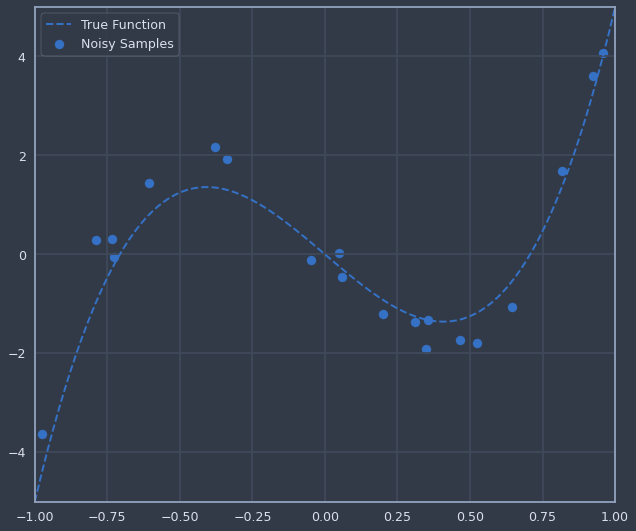

In [12]:
def fake_y(x, add_noise=False):
    y = 10 * x ** 3 - 5 * x
    return y + torch.randn_like(y) * 0.5 if add_noise else y


N = 20
min_x, max_x = -1, 1

x_true = torch.linspace(min_x, max_x, 100)
y_true = fake_y(x_true)

x_train = torch.rand(N) * (max_x - min_x) + min_x
y_train = fake_y(x_train, add_noise=True)

plot_regression_data()

# Train A Simple Linear Model Using Batch GD

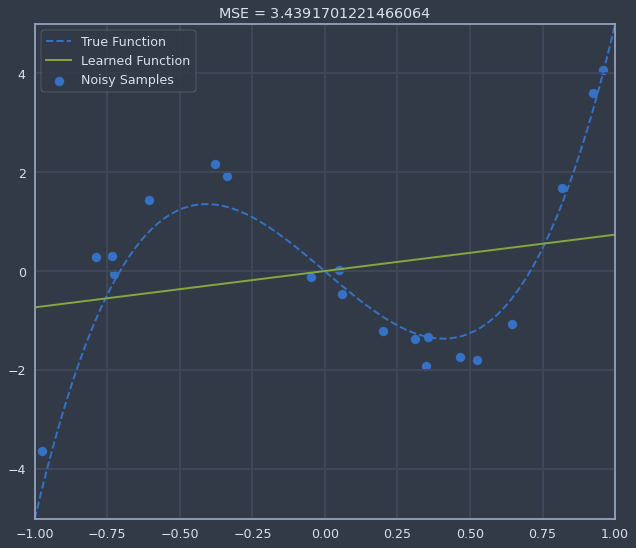

In [13]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 100

# Model parameters
m = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

params = (b, m)

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params, lr=learning_rate)

# Regression
for epoch in range(num_epochs):
    # Model
    yhat = m * x_train + b

    # Update parameters
    optimizer.zero_grad()
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(lambda x: m * x + b, MSE=loss.item())

# Train Linear Regression Model Using Batch GD

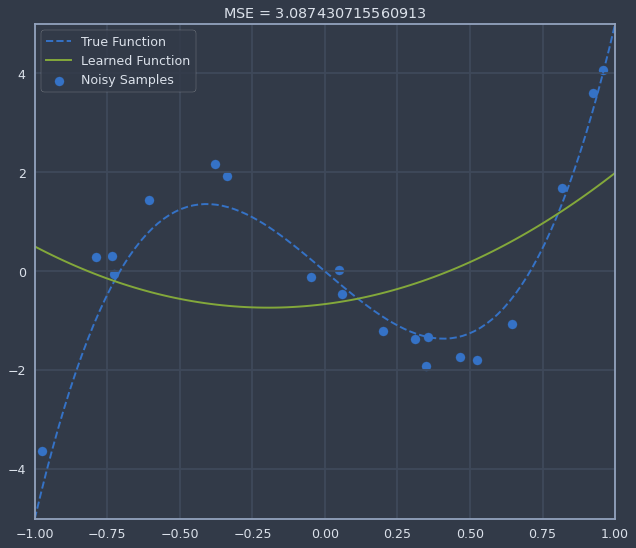

In [14]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 1000

# Model parameters
w2 = torch.randn(1, requires_grad=True)
w1 = torch.randn(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

params = (b, w1, w2)

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params, lr=learning_rate)

# Regression
for epoch in range(num_epochs):
    # Model
    yhat = b + w1 * x_train + w2 * x_train ** 2

    # Update parameters
    optimizer.zero_grad()
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(lambda x: b + w1 * x + w2 * x ** 2, MSE=loss.item())

# Train Complex Linear Regression Model Using Batch GD

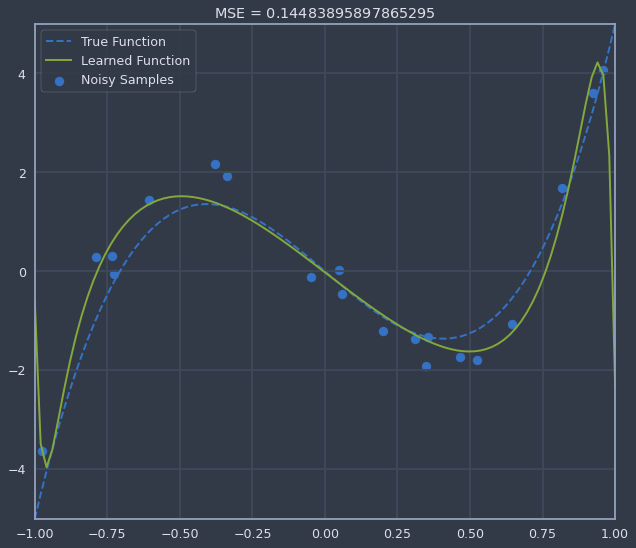

In [20]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 1000

# Model parameters
degrees = 50  # 3, 4, 16, 32, 64, 128
powers = torch.arange(degrees + 1)
x_poly = x_train.unsqueeze(-1).pow(powers)
params = torch.randn(degrees + 1, requires_grad=True)

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD([params], lr=learning_rate)

# Regression
for epoch in range(num_epochs):
    # Model
    yhat = x_poly @ params

    # Update parameters
    optimizer.zero_grad()
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(lambda x: x @ params, poly_deg=degrees, MSE=loss.item())

In [21]:
params

tensor([-0.0204, -4.5011, -0.0655,  4.7511, -0.7362,  1.7396,  1.7809,  3.6358,
         1.1388,  1.9494, -0.3424,  1.3367,  1.1814, -0.4819, -0.1168, -0.7331,
        -2.7082,  0.3308,  1.1197, -1.2823, -0.1924,  0.9937, -1.4247, -0.8745,
        -0.8355,  0.0916,  1.5228,  0.4127, -0.0727, -0.6952, -1.7243, -0.1128,
        -0.0336, -0.3079, -1.2522,  0.3615,  0.0474,  0.9505, -0.3162, -1.7258,
         0.8490, -0.6889,  0.3531, -1.6544, -0.1276, -1.1015,  0.0456, -1.5072,
         0.5120, -1.7460, -0.0442], requires_grad=True)

# Compute Linear Regression Model Using Ordinary Least Squares

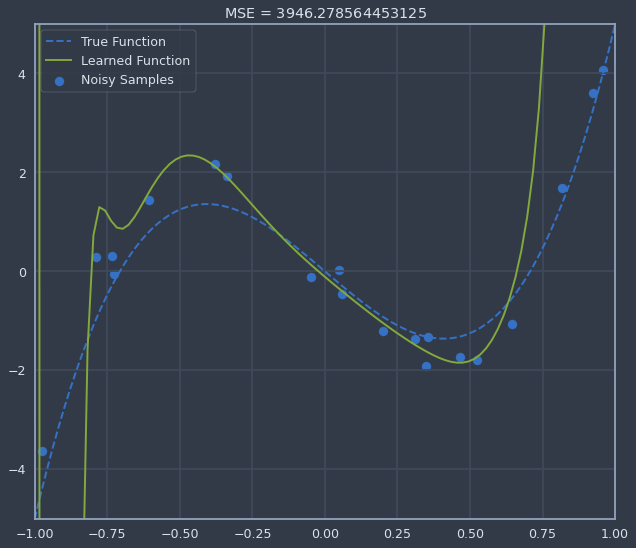

In [22]:
params = ((x_poly.T @ x_poly).inverse() @ x_poly.T) @ y_train
mse = torch.nn.functional.mse_loss(x_poly @ params, y_train)
plot_regression_data(lambda x: x @ params, poly_deg=degrees, MSE=mse)
# params

In [23]:
params

tensor([-1.1180e-01, -4.9632e+00,  1.9188e+00, -5.9799e+00,  1.7991e+01,
         4.1037e+01, -1.6814e+02, -5.7092e+01,  4.4391e+02,  2.7334e+02,
        -2.5960e+02, -3.9416e+02, -5.5256e+02, -8.3289e+01,  4.7960e+02,
         5.1446e+01,  4.4971e+02,  1.6077e+02,  1.0309e+02,  5.9582e+01,
         5.0117e+02,  9.2657e+02,  2.9047e+02, -2.8024e+02, -1.2873e+03,
        -7.2436e+02, -5.8948e+02,  3.0425e+02, -1.5532e+03,  4.4877e+02,
         3.2107e+02,  9.1614e+02,  2.2326e+01,  9.3557e+02,  7.8006e+02,
         6.9279e+02, -8.0174e+02, -1.1190e+03, -6.3913e+02, -2.8898e+03,
         6.7655e+01,  6.7786e+02,  1.4268e+03,  9.4594e+02, -8.0543e+02,
        -9.6150e+02,  4.9851e+02, -1.7245e+03,  2.9560e+02,  1.8119e+03,
         1.7530e+03])

# Train Neural Network Model Using Batch GD

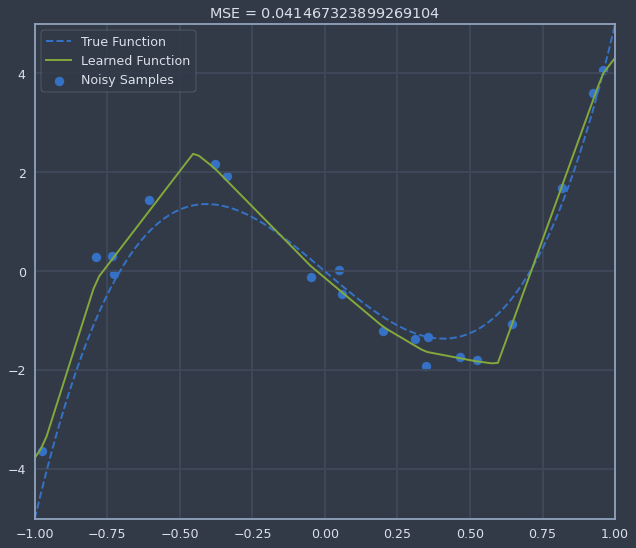

In [24]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 100000
regularization =  1e-2

# Model parameters
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

# Torch utils
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=regularization
)

# Training
for epoch in progress_bar(range(num_epochs)):
    # Model
    yhat = model(x_train.unsqueeze(-1))

    # Update parameters
    optimizer.zero_grad()
    loss = criterion(yhat.squeeze(), y_train)
    loss.backward()
    optimizer.step()

plot_regression_data(model, loss.item())

In [18]:
for param in model.parameters():
    print(param.mean())

tensor(-0.0212, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(-0.0008, grad_fn=<MeanBackward0>)
tensor(-0.0142, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(-0.0032, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(-0.1043, grad_fn=<MeanBackward0>)
